# **Practico 3 y 4 (parte 4): Balance de clases**

### Tabla de Contenidos
1. [Consigna](#1.-Consigna)
2. [Inicialización del entorno](#2.-Inicialización-del-entorno)
3. [Carga de datos](#3.-Carga-de-datos)
4. [Análisis del balance de clases](#4.-Análisis-del-balance-de-clases)
5. [División y normalización de los datos](#5.-División-y-normalización-de-los-datos)
6. [Baseline](#6.-Baseline)
7. [Penalizar la clase mayoritaria mediante hiperparámetro](#7.-Penalizar-la-clase-mayoritaria-mediante-hiperparámetro)
8. [Undersampling en la clase mayoritaria](#8.-Undersampling-en-la-clase-mayoritaria)
9. [Oversampling de la clase minoritaria](#9.-Oversampling-de-la-clase-minoritaria)
10. [Combinación de undersampling y oversampling: SMOTE-Tomek](#10.-Combinación-de-undersampling-y-oversampling:-SMOTE-Tomek)
11. [Comparación y conclusiones](#11.-Comparación-y-conclusiones)

## 1. Consigna

### **Ejercicio 4 de preparación: Balance de clases**
​
Queremos analizar el balance de nuestras clases. Para eso, analizamos cuántos diálogos caen en cada clase que predicen nuestros modelos. Enunciar claramente cuáles son las clases y si están o no balanceadas. 
​
Si la distribución es muy desigual resulta dificil aplicar técnicas como el subsampling porque nos quedaríamos con muy pocos datos de entrenamiento, o el oversampling porque para que las clases queden parejas, deberíamos repetir un mismo diálogo muchas veces.
​
Si la distribución no es tan desigual, hacer subsampling de diálogos completos y guardarlos como un nuevo dataset. A partir de ahora, todos los experimentos que corran deberán correrlos también para este nuevo corpus con sus clases balanceadas. Luego vamos a comparar los resultados obtenidos con y sin balanceo de clases
​

## 2. Inicialización del entorno

### **Librería: imbalanced-learn**

Usaremos [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/) una librería que permite realizar under-sampling y over-sampling con distintos métodos y es compatible con scikit-learn

In [1]:
#pip install -U imbalanced-learn

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

### **Inclusión de las otras librerias y módulos**

In [2]:
#Librerías 
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import pandas.util.testing as tm
# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from scipy import stats
from collections import Counter


# Para dividir el dataset en train  y test
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Gradiente Descendente
from sklearn.linear_model import SGDClassifier
# Algoritmo del Árbol de Decisión
from sklearn.tree import (DecisionTreeClassifier, plot_tree)

# Métricas
from sklearn.metrics import (confusion_matrix, classification_report)

# Para la Normalización 
from sklearn.preprocessing import StandardScaler

#Colors
BLUE   = '#5DADE2'
RED    = '#ff7043'
ORANGE = '#F5B041'
GREEN  = '#58D68D'
YELLOW = '#F4D03F'

# Utiles
from utiles import basic_metrics
from utiles import plot_cm
from utiles import plot_roc_pr

# Classes
classes = ['0 - Negativa', '1 - Positiva']

### **Funciones**

Definimos algunas funciones que nos permitirán correr el modelo, evaluarlo e informar los resultados para cada estrategia abordada para tratar el caso de los datos desbalanc

In [3]:
# Entrena el modelo y retorna el modelo entrenado
def entrenar_modelo(X_train, X_test, y_train, y_test):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    return dt

# Entrena el modelo con ponderación para las clases
def entrenar_modelo_ponderado(X_train, X_test, y_train, y_test, weights):
    dt = DecisionTreeClassifier(random_state=42, class_weight=weights)
    dt.fit(X_train, y_train)
    return dt

# Informa los reultados obtenidos mediante la matriz de confusión (heatmap) y classification_report
def informar_resultados(y_test, pred_y,y_test_pred_prob,Title=''):
    print (classification_report(y_test, pred_y))
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=classes, yticklabels=classes, annot=True, fmt="d", cmap='Greens', linecolor='black', linewidths=1, square=True, cbar=False);
    plt.title("Confusion matrix")
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()
    plot_roc_pr(y_test,  pred_y, y_test_pred_prob, Title= Title + ' - ROC PR',  x_text=0.4, y_text=0.2, size_text=12, size=(12,5), ms=15, colorR=ORANGE, colorP=GREEN, label=None);

# Muestra la distribución despues de cambiar el muestreo
def mostrar_distribucion(y_train, y_train_res):
    print ("\nDistribución antes de cambiar el muestreo:")
    for key, value in Counter(y_train).items():
        print('\tClase {}: '.format(key), value)
    print ("\n")
    print ("Distribución después de cambiar el muestreo:")
    for key, value in Counter(y_train_res).items():
        print('\tClase {}: '.format(key), value)
    print ("\n")


## 3. Carga de datos

El archivo `yup_curated_data.csv` se genera a partir del archivo `yup_messages_preprocessed.csv` y `datadump-20150801-20171219.csv` y se cura para se utilizado en el presente notebook.

In [4]:
filename = 'yup_curated_data.csv'  
datos_curados = pd.read_csv(os.path.join('..', 'dataset', filename))
datos_curados = datos_curados.drop(['tokens_tutor', 'tokens_student'], axis=1)

## 4. Análisis del balance de clases

In [5]:
print("\nCantidad de sesiones: {}\n".format(datos_curados.shape[0]))
print("Sesiones calificadas Negativas (clase 0): {}\n"
      .format(pd.value_counts(datos_curados['student_rating_cat'])[0]))
print("Sesiones calificadas Positivas (clase 1): {}\n"
      .format(pd.value_counts(datos_curados['student_rating_cat'])[1]))
print("Relación entre la clase minoritaria y mayoritaria: {:.2%}\n"
      .format(pd.value_counts(datos_curados['student_rating_cat'])[0]
              /pd.value_counts(datos_curados['student_rating_cat'])[1]))


Cantidad de sesiones: 17429

Sesiones calificadas Negativas (clase 0): 3598

Sesiones calificadas Positivas (clase 1): 13831

Relación entre la clase minoritaria y mayoritaria: 26.01%



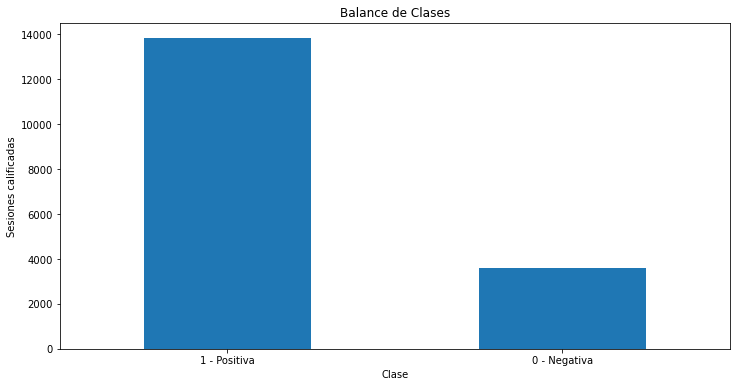

In [6]:
plt.figure(figsize=(12, 6))
count_student_rating = pd.value_counts(datos_curados['student_rating_cat'], sort = True)
count_student_rating.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['1 - Positiva', '0 - Negativa'])
plt.title("Balance de Clases")
plt.xlabel("Clase")
plt.ylabel("Sesiones calificadas");
plt.show()

## 5. División y normalización de los datos
1. El conjunto de datos es dividido en datos de entrada o alimentación y en la referencia o target al cual debe apuntar el clasificador al momento de predecir.

1. Se divide nuevamente al conjunto de datos en datos de entrenamiento o train y  datos de evaluación o test, cada uno de ellos con su correspondiente referencia o target.

In [7]:
#1. División entre datos de entrada y referencia o target
X, y = datos_curados.iloc[:, :-1], datos_curados.student_rating_cat

#2. División entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Se crea el objeto del modelo y se imprimen los parametros por defecto que posee el modelo. Se fija la semilla para hacer reproducible el experimento.

## 6. Baseline

Como baseline usaremos un modelo de Decision Tree con los hiperparámetros por defecto. Este constituirá la referencia para comparar con los resultados obtenidos al tratar de abordar el problema del desbalanceo de clases mediante distintas estrategias.

              precision    recall  f1-score   support

           0       0.35      0.37      0.36       699
           1       0.84      0.83      0.83      2787

    accuracy                           0.74      3486
   macro avg       0.60      0.60      0.60      3486
weighted avg       0.74      0.74      0.74      3486



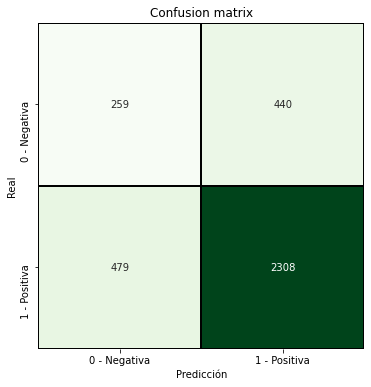

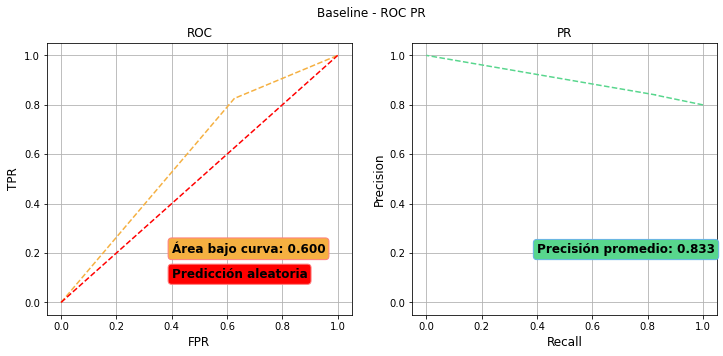

In [8]:
#1. Entrenamos el modelo con los valores por defecto
modelo = entrenar_modelo(X_train, X_test, y_train, y_test)

#2. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test)
y_predp = modelo.predict_proba(X_test)

#3. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "Baseline")

## 7. Penalizar la clase mayoritaria mediante hiperparámetro

Sin intervenir en en conjunto de datos, intentaremos penalizar la diferencia de clases mediante el hiperparámetro `class_weight` que admiten algunos modelos de scikit-learn

              precision    recall  f1-score   support

           0       0.35      0.37      0.36       699
           1       0.84      0.83      0.83      2787

    accuracy                           0.74      3486
   macro avg       0.60      0.60      0.60      3486
weighted avg       0.74      0.74      0.74      3486



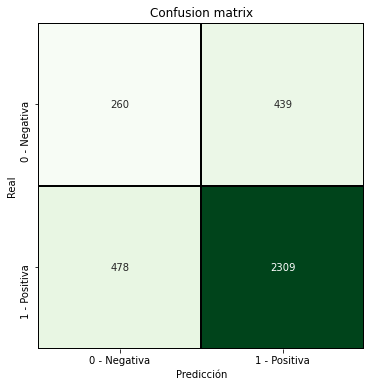

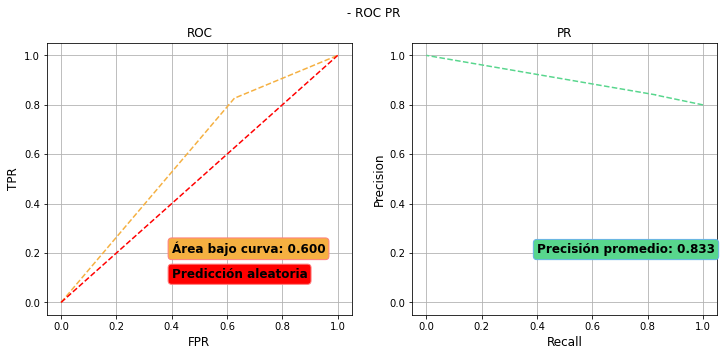

In [9]:
#1. Entrenamos el modelo usando class_weight 
modelo = entrenar_modelo_ponderado(X_train, X_test, y_train, y_test, weights = {0:50, 1:25},)

#2. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test, )
y_predp = modelo.predict_proba(X_test)

#3. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "")

## 8. Undersampling en la clase mayoritaria

Vamos a reducir la cantidad de muestras de la clase mayoritaria. Existen varias alternativas para realizar [under-sampling](https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html?highlight=under-sampling#), en este caso usaremos el método [NearMiss](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html#imblearn.under_sampling.NearMiss)


Distribución antes de cambiar el muestreo:
	Clase 0:  2899
	Clase 1:  11044


Distribución después de cambiar el muestreo:
	Clase 0:  2899
	Clase 1:  9663


              precision    recall  f1-score   support

           0       0.29      0.46      0.36       699
           1       0.84      0.72      0.78      2787

    accuracy                           0.67      3486
   macro avg       0.57      0.59      0.57      3486
weighted avg       0.73      0.67      0.69      3486



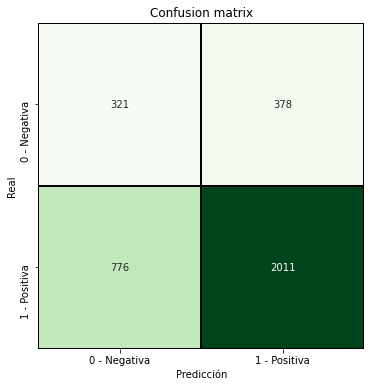

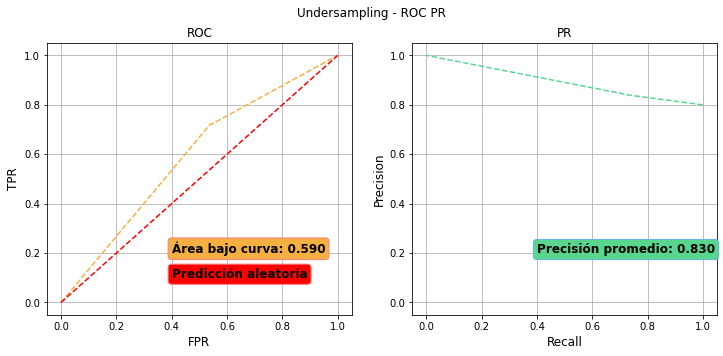

In [10]:
#1 Subsampling usando NearMiss
under_sampling = NearMiss(sampling_strategy=0.3, n_neighbors=4, version=2)
X_train_res, y_train_res = under_sampling.fit_sample(X_train, y_train)
 
#2 Mostramos la distribución de los datos de entrenamiento antes y despúes del proceso
mostrar_distribucion (y_train, y_train_res)

#3. Entrenamos el modelo usando class_wight 
modelo = entrenar_modelo(X_train_res, X_test, y_train_res, y_test)

#4. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test)
y_predp = modelo.predict_proba(X_test)

#5. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "Undersampling")

## 9. Oversampling de la clase minoritaria



### Oversampling usando `RandomOverSampler`

Esta alternativa consiste en agregar muestras sintéticas a la clase minoritaria. Usaremos el método [RandomOverSampler](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.RandomOverSampler.html?highlight=randomoversampling)


Distribución antes de cambiar el muestreo:
	Clase 0:  2899
	Clase 1:  11044


Distribución después de cambiar el muestreo:
	Clase 0:  5522
	Clase 1:  11044


              precision    recall  f1-score   support

           0       0.35      0.39      0.37       699
           1       0.84      0.82      0.83      2787

    accuracy                           0.73      3486
   macro avg       0.60      0.60      0.60      3486
weighted avg       0.74      0.73      0.74      3486



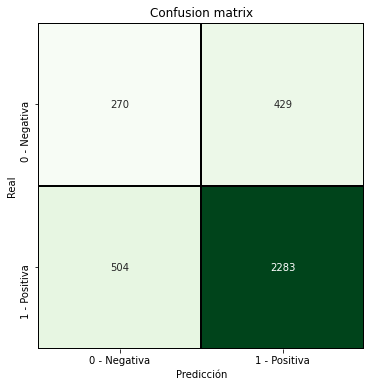

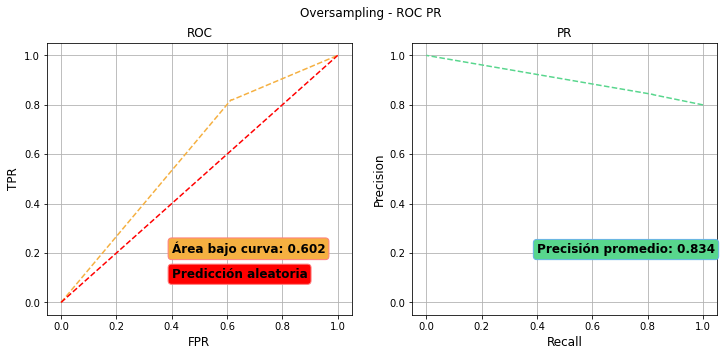

In [11]:
#1 Oversampling usando RandoOverSampler
over_sampling =  RandomOverSampler(sampling_strategy=0.5, random_state=0)
X_train_res, y_train_res = over_sampling.fit_sample(X_train, y_train)
 
#2 Mostramos la distribución de los datos de entrenamiento antes y despúes del proceso
mostrar_distribucion (y_train, y_train_res)

#3. Entrenamos el modelo usando class_wight 
modelo = entrenar_modelo(X_train_res, X_test, y_train_res, y_test)

#4. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test)
y_predp = modelo.predict_proba(X_test)

#5. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "Oversampling")

### Oversampling usando `SMOTE`

Exploramos la alternativa [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) (Synthetic Minority Oversampling Technique) que es una técnica para generar datos de la clase minoritaria basada en KNN


Distribución antes de cambiar el muestreo:
	Clase 0:  2899
	Clase 1:  11044


Distribución después de cambiar el muestreo:
	Clase 0:  4417
	Clase 1:  11044


              precision    recall  f1-score   support

           0       0.33      0.40      0.36       699
           1       0.84      0.79      0.82      2787

    accuracy                           0.71      3486
   macro avg       0.58      0.60      0.59      3486
weighted avg       0.74      0.71      0.72      3486



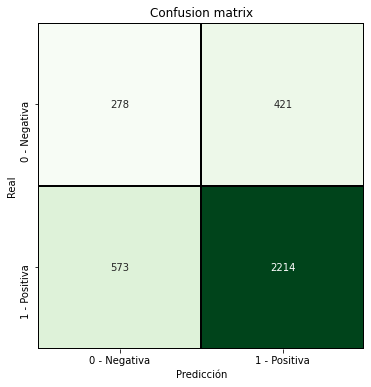

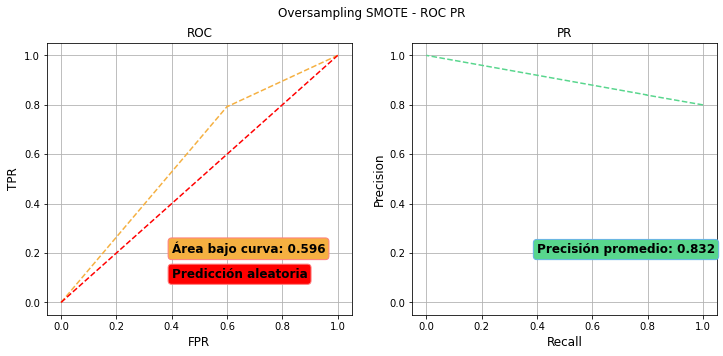

In [12]:
#1 Oversampling usando SMOTE
over_sampling_SMOTE =  SMOTE(sampling_strategy=0.4, k_neighbors=3, random_state=0)
X_train_res, y_train_res = over_sampling_SMOTE.fit_sample(X_train, y_train)
 
#2 Mostramos la distribución de los datos de entrenamiento antes y despúes del proceso
mostrar_distribucion (y_train, y_train_res)

#3. Entrenamos el modelo usando class_wight 
modelo = entrenar_modelo(X_train_res, X_test, y_train_res, y_test)

#4. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test)
y_predp = modelo.predict_proba(X_test)

#5. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "Oversampling SMOTE")

## 10. Combinación de undersampling y oversampling: SMOTE-Tomek

Usaremos el método [SMOTETomek](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.combine.SMOTETomek.html?highlight=smotetomek) para combinar **over-sampling** y **under-sampling**



Distribución antes de cambiar el muestreo:
	Clase 0:  2899
	Clase 1:  11044


Distribución después de cambiar el muestreo:
	Clase 0:  4589
	Clase 1:  10111


              precision    recall  f1-score   support

           0       0.33      0.39      0.36       699
           1       0.84      0.80      0.82      2787

    accuracy                           0.72      3486
   macro avg       0.58      0.60      0.59      3486
weighted avg       0.74      0.72      0.73      3486



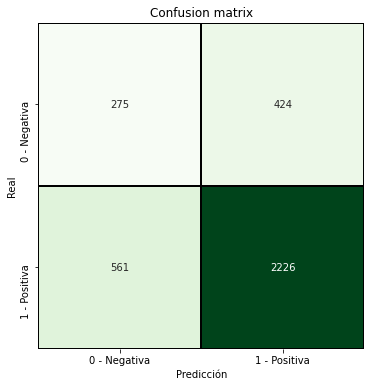

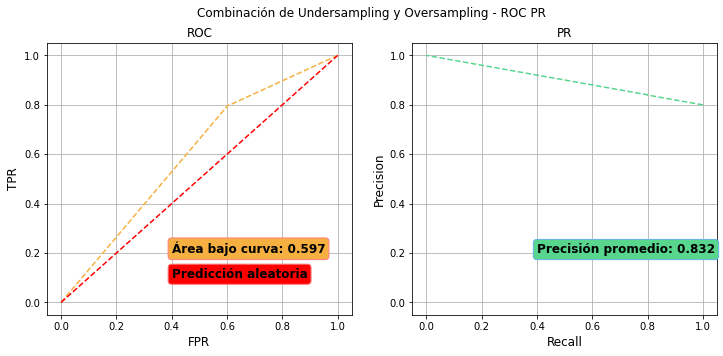

In [13]:
#1 Combinación de over y under sampling usando SMOTE-Tomek
combinacion = SMOTETomek(sampling_strategy=0.5, random_state=0)
X_train_res, y_train_res = combinacion.fit_sample(X_train, y_train)
 
#2 Mostramos la distribución de los datos de entrenamiento antes y despúes del proceso
mostrar_distribucion (y_train, y_train_res)

#3. Entrenamos el modelo usando class_wight 
modelo = entrenar_modelo(X_train_res, X_test, y_train_res, y_test)

#4. Obtenemos las predicciones para el conjunto de evaluación 
y_pred = modelo.predict(X_test)
y_predp = modelo.predict_proba(X_test)

#5. Informamos los resultados
informar_resultados(y_test, y_pred, y_predp[:,1], "Combinación de Undersampling y Oversampling")

## 11. Comparación y conclusiones




A partir de la comparación de las métricas obtenidas sobre el conjunto de evaluación (f1 score y Area bajo la Curva ROC) se observa que la aplicación de estas estrategias no ha resultado en un beneficio significativo.

Aunque entre las alternativas exploradas en el caso de Oversampling con el método RandomOverSampler se logró incrementar el desempeño en la detección de la clase minoritaria